In [25]:
# 3. Supply Chain Efficiency Improvement Project

# 3.1 Introduction
# This project aims to analyze supplier performance and identify bottlenecks in order fulfillment processes to enhance the overall efficiency of the supply chain.


In [26]:
# 3.2 Data Preparation

# import libraries
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# load datasets
orders = pd.read_csv('Orders Table.csv')
products = pd.read_csv('Products Table.csv')

# merge datasets on ProductID
data = pd.merge(orders, products, on='ProductID', how='left')

In [27]:
# 3.3 Data Inspection

# inspect the datasets
print(orders.head())
print(products.head())

# check for missing values
print(orders.isnull().sum())
print(products.isnull().sum())

# no empty values, good to go!

   Unnamed: 0  OrderID  ProductID  CustomerID       Order Date  \
0           0    77202       5246       15795  1/31/2018 22:56   
1           1    75939       2362         860  1/13/2018 12:27   
2           2    75938      13940       76820  1/13/2018 12:06   
3           3    75937       1105       54886  1/13/2018 11:45   
4           4    75936       2987        6265  1/13/2018 11:24   

     Shipping Date  Actual days for shipping  Scheduled days for shipping  \
0     2/3/18 22:56                         3                            4   
1  1/18/2018 12:27                         5                            4   
2  1/17/2018 12:06                         4                            4   
3  1/16/2018 11:45                         3                            4   
4  1/15/2018 11:24                         2                            4   

   Late Delivery Risk  Discount Percentage  Returns  Promotional Period  \
0                   0                 0.04        0              

In [28]:
# 3.4 Data Cleaning

# convert date columns to datetime format
orders['Order Date'] = pd.to_datetime(orders['Order Date'], dayfirst=True, errors='coerce')
orders['Shipping Date'] = pd.to_datetime(orders['Shipping Date'], dayfirst=True, errors='coerce')

<ipython-input-28-90c4dd62ec3b>:4: UserWarning: Parsing dates in %m/%d/%Y %H:%M format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  orders['Order Date'] = pd.to_datetime(orders['Order Date'], dayfirst=True, errors='coerce')
<ipython-input-28-90c4dd62ec3b>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  orders['Shipping Date'] = pd.to_datetime(orders['Shipping Date'], dayfirst=True, errors='coerce')


In [29]:
# 3.5 Exploratory Data Analysis (EDA) & Bottleneck Identification

# 3.5.1 Descriptive Analysis
# 3.5.1.1 Summary Statistics
summary_stats = data.describe()
print("Summary Statistics:")
print(summary_stats)

# Insights from Summary Statistics:
# 1) Orders Table:
#    - There are 168946 orders.
#    - The average actual shipping time is approximately 3.5 days.
#    - The late delivery risk is present in about 55% of the orders.
#    - On average, each order contains about 2.12 items.
#    - Returns occur in about 10% of the cases.

# 2) Products Table:
#    - There are 20,462 unique products.
#    - The prices ranging widely from $0.47 to $1,678.80.
#    - There are 150 unique suppliers.

Summary Statistics:
          Unnamed: 0        OrderID      ProductID     CustomerID  \
count  168946.000000  168946.000000  168946.000000  168946.000000   
mean    84472.500000   36332.689984   10225.686207   49949.200987   
std     48770.653627   21116.094007    5898.147289   28929.380086   
min         0.000000       1.000000       1.000000       1.000000   
25%     42236.250000   18105.000000    5129.000000   24737.000000   
50%     84472.500000   36260.000000   10226.000000   50031.000000   
75%    126708.750000   54301.000000   15336.000000   75092.750000   
max    168945.000000   77204.000000   20462.000000   99999.000000   

       Actual days for shipping  Scheduled days for shipping  \
count             168946.000000                168946.000000   
mean                   3.498574                     2.932268   
std                    1.624919                     1.374945   
min                    0.000000                     0.000000   
25%                    2.000000       

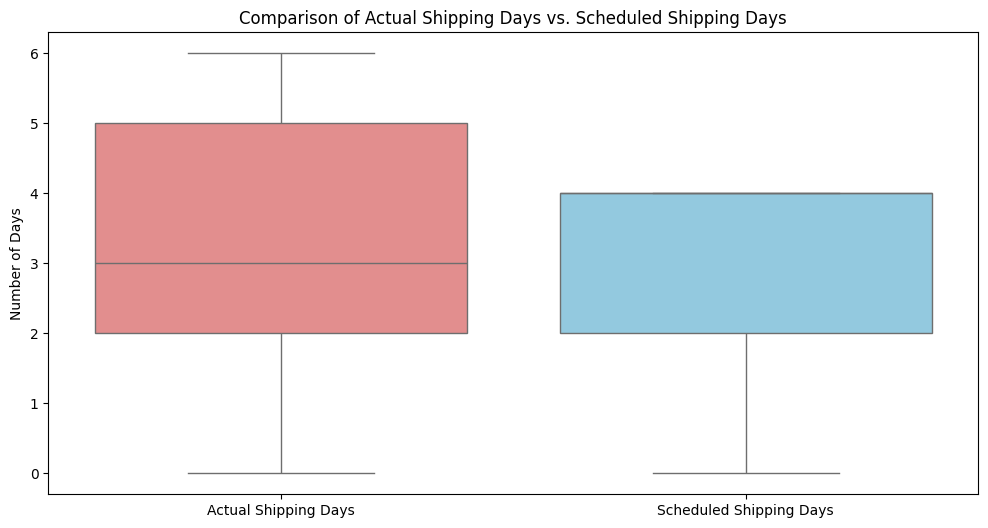

In [30]:
# 3.5.1.2 Box Plot: Actual Shipping Days vs. Scheduled Shipping Days

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['Actual days for shipping', 'Scheduled days for shipping']],
            palette=["lightcoral","skyblue"])
plt.title('Comparison of Actual Shipping Days vs. Scheduled Shipping Days')
plt.ylabel('Number of Days')
plt.xticks(ticks=[0, 1], labels=['Actual Shipping Days', 'Scheduled Shipping Days'])
plt.show()

# Insights from Box Plots:
# 1) Median and IQR(Q3-Q1) of actual shipping days > scheduled days,
#    indicating inefficiencies in order fulfillment and potentially negative impact on customer satisfaction.
# 2) Next step will identify product categories/suppliers with longer shipping times


Supplier Performance Analysis (Late Delivery Percentage >= 60%):
     Supplier_ID  late_delivery_count  total_sales  late_delivery_percentage
26            27                    4            5                 80.000000
43            44                   16           20                 80.000000
2              3                   70           96                 72.916667
48            49                    7           10                 70.000000
14            15                   42           61                 68.852459
33            34                    2            3                 66.666667
25            26                  132          200                 66.000000
73            74                   53           81                 65.432099
105          106                   98          151                 64.900662
108          109                   75          116                 64.655172
64            65                   80          128                 62.500000
23         

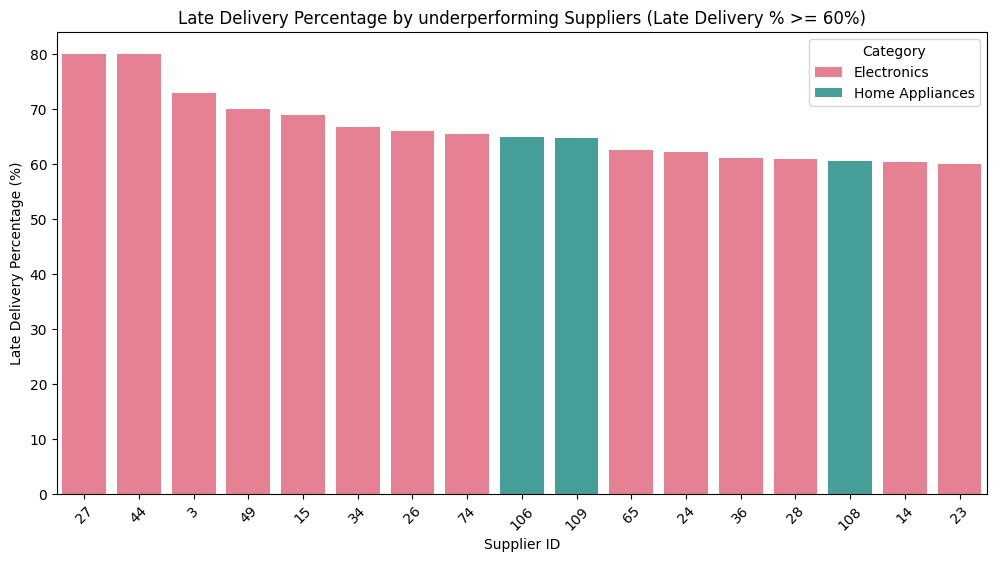

Percentage of underperforming Suppliers by Category (Late Delivery Percentage >= 60%):
          Category  total_suppliers  underperforming_suppliers  \
0         Clothing               33                        0.0   
1      Electronics               83                       14.0   
2  Home Appliances               34                        3.0   

   percentage_underperforming  
0                    0.000000  
1                   16.867470  
2                    8.823529  


In [31]:
# 3.5.2 Supplier Performance Analysis

# disclaimer: we did not include bar chart (Late Delivery Risk by Product Category) here as every categories have 50%-55% late delivery risk,

# hence, we try to analyze late delivery risk by suppliers now
supplier_performance = data.groupby('Supplier_ID').agg(
    late_delivery_count=('Late Delivery Risk', lambda x: (x == 1).sum()),
    total_sales=('ProductID', 'count')
).reset_index()

# calculate late delivery percentage for each supplier
supplier_performance['late_delivery_percentage'] = (supplier_performance['late_delivery_count'] / supplier_performance['total_sales']) * 100

# we classified suppliers with a late delivery percentage of >= 60% as underperforming suppliers,
# while those with a lower percentage are categorized as high-performing suppliers.
underperforming_suppliers = supplier_performance[supplier_performance['late_delivery_percentage'] >= 60]
underperforming_suppliers_sorted = underperforming_suppliers.sort_values(by='late_delivery_percentage', ascending=False)
print("Supplier Performance Analysis (Late Delivery Percentage >= 60%):")
print(underperforming_suppliers_sorted)

# categorize suppliers
underperforming_categories = data[data['Supplier_ID'].isin(underperforming_suppliers_sorted['Supplier_ID'])]

# merge the supplier performance with their categories
underperforming_suppliers_sorted = pd.merge(underperforming_suppliers_sorted, underperforming_categories[['Supplier_ID', 'Category']], on='Supplier_ID', how='left')

# Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=underperforming_suppliers_sorted, x='Supplier_ID', y='late_delivery_percentage', hue='Category', palette='husl', order=underperforming_suppliers_sorted['Supplier_ID'])
plt.title('Late Delivery Percentage by underperforming Suppliers (Late Delivery % >= 60%)')
plt.xlabel('Supplier ID')
plt.ylabel('Late Delivery Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.show()

# count total suppliers and underperforming suppliers
total_suppliers_by_Category = data.groupby('Category')['Supplier_ID'].nunique().reset_index(name='total_suppliers')
underperforming_suppliers_by_Category = underperforming_categories.groupby('Category')['Supplier_ID'].nunique().reset_index(name='underperforming_suppliers')

# merge the two dataframes to calculate percentages
Category_analysis = pd.merge(total_suppliers_by_Category, underperforming_suppliers_by_Category, on='Category', how='left')
Category_analysis['underperforming_suppliers'] = Category_analysis['underperforming_suppliers'].fillna(0)
Category_analysis['percentage_underperforming'] = (Category_analysis['underperforming_suppliers'] / Category_analysis['total_suppliers']) * 100
print("Percentage of underperforming Suppliers by Category (Late Delivery Percentage >= 60%):")
print(Category_analysis[['Category', 'total_suppliers', 'underperforming_suppliers', 'percentage_underperforming']])

# Insights from Suppliers Performance Analysis:
# 1) There are 14 Electronics Suppliers and 3 Home Appliances Suppliers are underperforming.
# 2) Are Electronics and Home Appliances harder to transit, leading to this result?
#    Ans: No. As mentioned before, every categories have 50%-55% late delivery risk, so we cannot tell the difference of each categories' difficulty in transit.


                       Order Country  avg_late_delivery_percentage
49                        Kazakhstan                    100.000000
67                Papúa Nueva Guinea                    100.000000
35                            Guinea                    100.000000
38                           Hungría                    100.000000
42                           Ireland                    100.000000
44                            Israel                    100.000000
46                           Jamaica                    100.000000
1                             Angola                    100.000000
50                             Kenia                    100.000000
51                        Kyrgyzstan                    100.000000
52                           Liberia                    100.000000
57                        Mozambique                    100.000000
63                            Norway                    100.000000
68                              Perú                    100.00

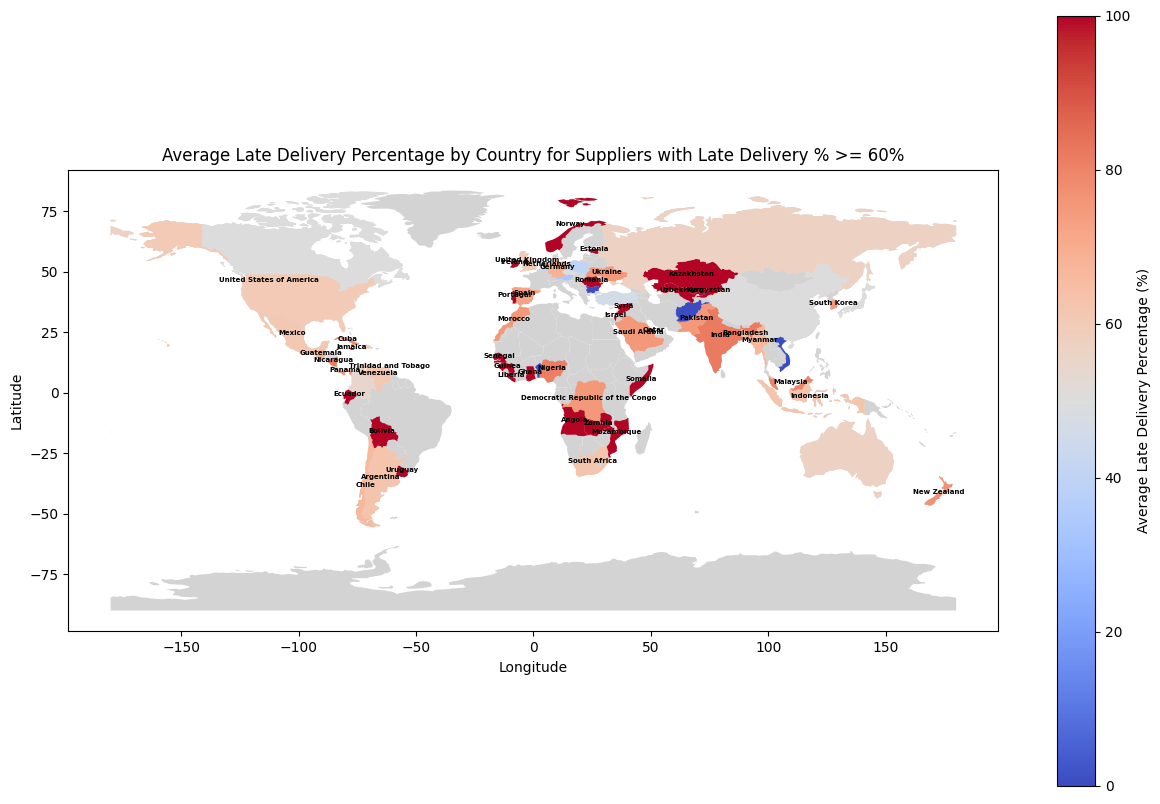

In [32]:
# 3.5.3 Order Fulfillment Process Analysis

# Now, we will identify underperforming suppliers in the countries they are responsible for,
# as this may indicate regional challenges such as customs clearance issues or inconvenient transportation.

# mapping dictionary for corrections
country_mapping = {
    'Japón': 'Japan',
    'Corea del Sur': 'South Korea',
    'Estados Unidos': 'United States of America',
    'República Democrática del Congo': 'Democratic Republic of the Congo',
    'República Dominicana': 'Dominican Republic',
    'Países Bajos': 'Netherlands',
    'Turquía': 'Turkey',
    'República Checa': 'Czechia',
    'Afganistán': 'Afghanistan',
    'SudAfrica': 'South Africa',
    'Baréin': 'Bahrain',
    'Malasia': 'Malaysia',
    'Emiratos Árabes Unidos': 'United Arab Emirates',
    'Siria': 'Syria',
    'Bangladés': 'Bangladesh',
    'Singapur': 'Singapore',
    'Panamá': 'Panama',
    'España': 'Spain',
    'México': 'Mexico',
    'Marruecos': 'Morocco',
    'Alemania': 'Germany',
    'Reino Unido': 'United Kingdom',
    'Nueva Zelanda': 'New Zealand',
    'Arabia Saudí': 'Saudi Arabia',
    'Kazajistán': 'Kazakhstan',
    'Uzbekistán': 'Uzbekistan',
    'Benín': 'Benin',
    'Ucrania': 'Ukraine',
    'Polonia': 'Poland',
    'Portugal': 'Portugal',
    'Rumania': 'Romania',
    'Trinidad y Tobago': 'Trinidad and Tobago',
    'Pakistán': 'Pakistan',
    'Finlandia': 'Finland',
    'Rusia': 'Russia',
    'Irlanda': 'Ireland',
    'Noruega': 'Norway',
    'Eslovaquia': 'Slovakia',
    'Bélgica': 'Belgium',
    'Bolivia': 'Bolivia',
    'Etiopía': 'Ethiopia',
    'Kirguistán': 'Kyrgyzstan',
    'Guinea': 'Guinea',
    'Eslovenia': 'Slovenia',
    'República de Gambia': 'Gambia',
    'Botsuana': 'Botswana',
    'Sáhara Occidental': 'Western Sahara',
    'Suazilandia': 'Eswatini',
    'Myanmar (Birmania)':'Myanmar'
}


# replace country names
data['Order Country'] = data['Order Country'].replace(country_mapping)

# print(data['Order Country'].unique())
# print(world['Order Country'].unique())

world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world = world.rename(columns={"ADMIN": "Order Country"})

supplier_performance = data.groupby(['Supplier_ID']).agg(
    late_delivery_count=('Late Delivery Risk', lambda x: (x == 1).sum()),
    total_sales=('ProductID', 'count')
).reset_index()

supplier_performance['late_delivery_percentage'] = (supplier_performance['late_delivery_count'] / supplier_performance['total_sales']) * 100
underperforming_suppliers = supplier_performance[supplier_performance['late_delivery_percentage'] >= 60]
underperforming_data = data[data['Supplier_ID'].isin(underperforming_suppliers['Supplier_ID'])]

# group the late delivery percentage by country
country_delay = underperforming_data.groupby('Order Country').agg(
    avg_late_delivery_percentage=('Late Delivery Risk', lambda x: (x == 1).sum() / len(x) * 100)
).reset_index()

# print the sorted countries with late delivery percentage > 60% in descending order
country_delay_sorted = country_delay.sort_values(by='avg_late_delivery_percentage', ascending=False)
high_delay_countries = country_delay_sorted[country_delay_sorted['avg_late_delivery_percentage'] > 60]
with pd.option_context('display.max_rows', None):
    print(high_delay_countries)

# merge with world data on the corrected country name column
merged_world = world.merge(country_delay, on="Order Country", how="left")

# plot the map with overlayed delay data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color="lightgrey")  # Background map
merged_world_with_data = merged_world[merged_world['avg_late_delivery_percentage'].notna()]
merged_world_with_data.plot(column='avg_late_delivery_percentage', ax=ax, legend=True,
                            cmap="coolwarm", legend_kwds={'label': "Average Late Delivery Percentage (%)"},
                            missing_kwds={"color": "lightgrey", "label": "No data"})

# add labels for countries with high late delivery percentages
high_delay_countries = merged_world_with_data[merged_world_with_data['avg_late_delivery_percentage'] >= 60]
for _, row in high_delay_countries.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['Order Country'],
             fontsize=5, ha='center', color='black', weight='bold')

plt.title('Average Late Delivery Percentage by Country for Suppliers with Late Delivery % >= 60%')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# Insights from Order Fulfillment Process Analysis:
# Ans: Based on the results, we can confidently say that regional challenges is one of the factors leading to high late delivery percentages in several countries.
# 1) Customs Clearance Issues: Zimbabue, Hungría, and Guinea have complicated customs procedures such as
#                              lengthy processing times, strict regulations, or lack of resources at customs facilities,  which can impede timely delivery.
# 2) Inconvenient Transportation: Papúa Nueva Guinea and Kyrgyzstan often have remote areas that are difficult to reach, leading to longer delivery times.
#                                 Infrastructure issues such as poor road conditions or inadequate logistics networks, can exacerbate these delays.
# 3) Political and Economic Factors: Venezuela and Democratic Republic of the Congo may face political instability or economic challenges that affect their logistics and supply chain operations.
# 4) Natural Disasters and Weather Conditions: Senegal is country prone to natural disasters or adverse weather conditions,
#                                              they may experience interruptions in logistics and transportation, further delaying deliveries.
# 5) Local Regulations: Regulatory environments can vary significantly between countries. Some countries like Peru, Níger, and Bulgaria
#                        may have more stringent import/export regulations that slow down the delivery process, contributing to high late delivery rates.

<ipython-input-33-da6b5ec636f9>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_analysis = orders.resample('M').agg({


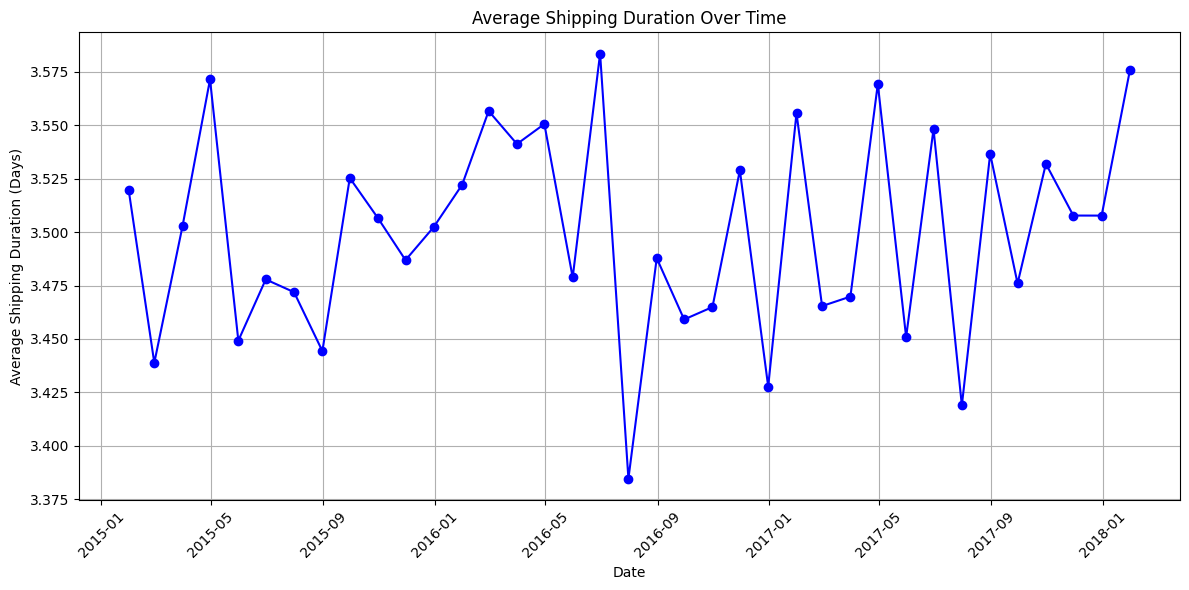

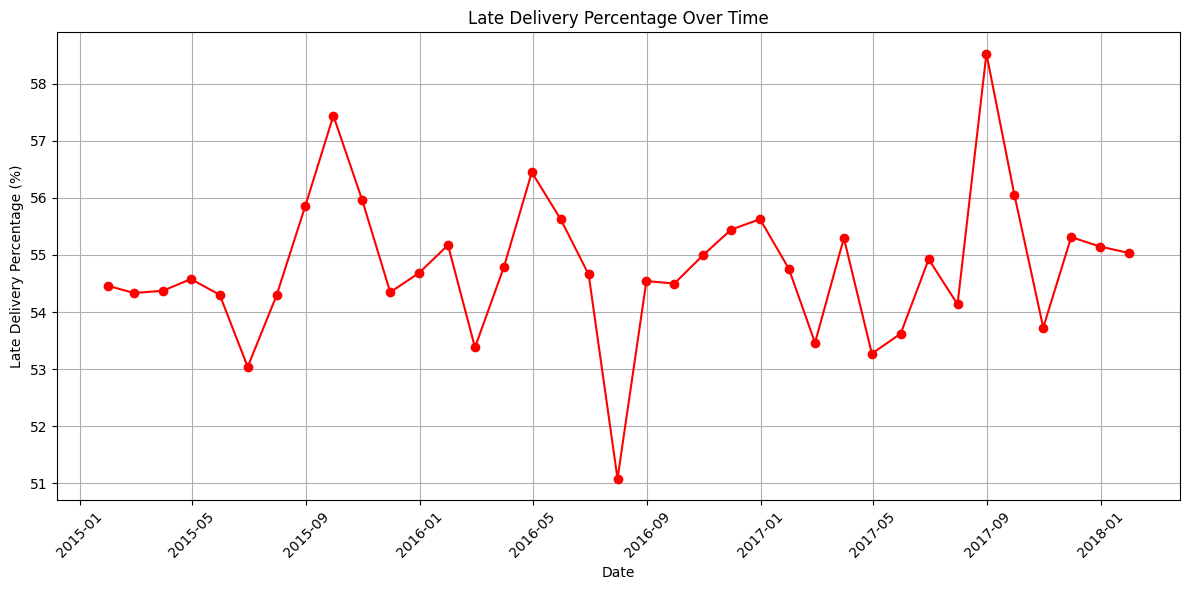

In [33]:
# 3.5.4 Time Series Analysis

# rename shipping duration
orders['Shipping Duration'] = orders['Actual days for shipping']

# convert 'Order Date' to datetime and set it as the index
orders.set_index('Order Date', inplace=True)

# resampling to calculate monthly average shipping duration and late delivery percentage
monthly_analysis = orders.resample('M').agg({
    'Shipping Duration': 'mean',
    'Late Delivery Risk': 'mean'  # This gives the percentage of late deliveries
}).rename(columns={'Late Delivery Risk': 'Late Delivery Percentage'})

monthly_analysis.reset_index(inplace=True)

# Time Series Analysis for Shipping Duration
plt.figure(figsize=(12, 6))
plt.plot(monthly_analysis['Order Date'], monthly_analysis['Shipping Duration'], marker='o', color='blue')
plt.title('Average Shipping Duration Over Time')
plt.xlabel('Date')
plt.ylabel('Average Shipping Duration (Days)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Time Series Analysis for Late Delivery Percentage
plt.figure(figsize=(12, 6))
plt.plot(monthly_analysis['Order Date'], monthly_analysis['Late Delivery Percentage'] * 100, marker='o', color='red')
plt.title('Late Delivery Percentage Over Time')
plt.xlabel('Date')
plt.ylabel('Late Delivery Percentage (%)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


# Insights Time Series Analysis:
# 1) Shipping Duration
#    - The average number of days for shipping appears to be relatively stable over years-months, ranging from 3.375 to 3.600.
# 2) Late Delivery Percentage
#    - The values over months are consistently high, indicating issues with specific suppliers or fulfillment processes.
#    - September 2015 and September 2017 are considered the 'peak' periods. The following events might have affected the supply chain:
#       - 2015 Sep: Hurricane Joaquin and European Migration Crisis.
#       - 2017 Sep: Hurricanes Harvey, Irma, and Maria at Atlantic and Labor Strikes in Spain.


     Supplier_ID  average_satisfaction  total_orders
109          110             39.767442            86
71            72             39.661017           177
4              5             39.493671           237
95            96             39.340659            91
101          102             39.307692           130
24            25             39.292929            99
52            53             39.130435            92
13            14             38.901099            91
22            23             38.857143            35
107          108             38.661972           142
27            28             38.048780            41
35            36             37.838828           273
64            65             36.718750           128
23            24             36.486486            37
108          109             34.396552           116
105          106             34.304636           151
73            74             33.827160            81
33            34             33.333333        

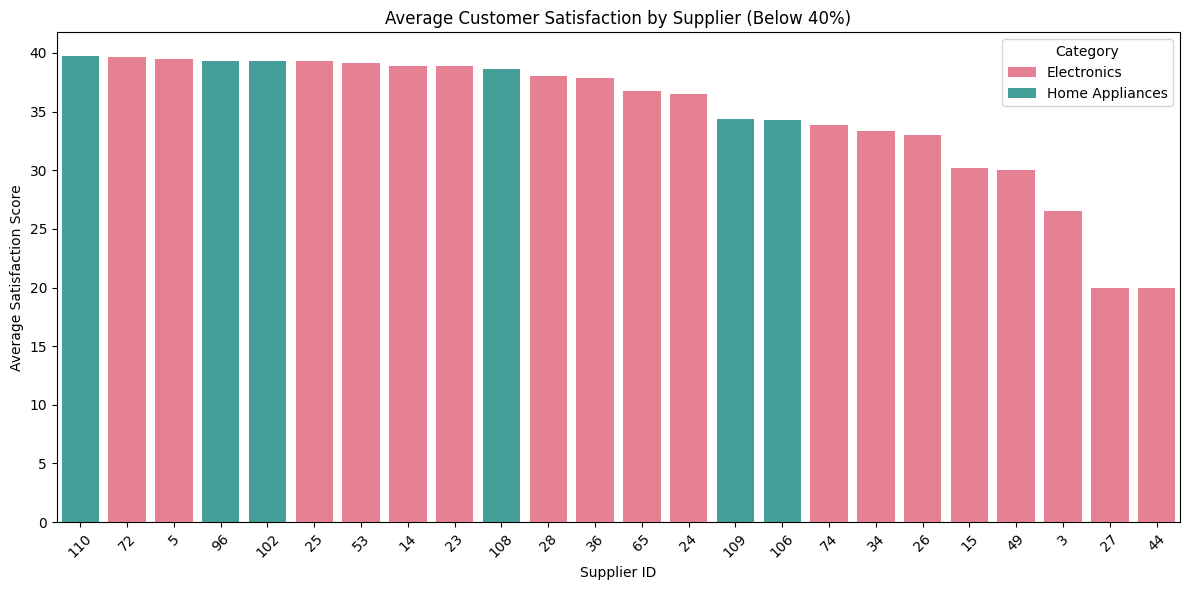


Common Suppliers in Both Lists:
[  3  14  15  23  24  26  27  28  34  36  44  49  65  74 106 108 109]
Percentage of common suppliers of both list in Average Customer Satisfaction by Supplier (Below 40)
70.83333333333334
Not Common Suppliers are from
['Home Appliances' 'Electronics']
Not Common Suppliers are:
[110  72   5  96 102  25  53]


In [34]:
# 3.5.5 Average Customer Satisfaction by Supplier

# Here, we assume lower late deliveries and fewer returns indicate higher satisfaction
data['Customer Satisfaction Score'] = 100 - (data['Late Delivery Risk'] * 100) - (data['Returns'] * 10)

# calculate the average customer satisfaction scores by supplier
customer_satisfaction_by_supplier = data.groupby('Supplier_ID').agg(
    average_satisfaction=('Customer Satisfaction Score', 'mean'),
    total_orders=('OrderID', 'count')
).reset_index()

# filter to only include suppliers with average satisfaction below 40
low_satisfaction_suppliers = customer_satisfaction_by_supplier[
    customer_satisfaction_by_supplier['average_satisfaction'] <= 40
]

# sort the filtered DataFrame in descending order of average satisfaction
low_satisfaction_suppliers_sorted = low_satisfaction_suppliers.sort_values(by='average_satisfaction', ascending=False)
print(low_satisfaction_suppliers_sorted)

# sort by average satisfaction in descending order and merge with Category information
low_satisfaction_suppliers_with_Category = pd.merge(
    low_satisfaction_suppliers_sorted,
    data[['Supplier_ID', 'Category']].drop_duplicates(),
    on='Supplier_ID',
    how='left'
).sort_values(by='average_satisfaction', ascending=False)

# plot with color-coded categories and sorted by average satisfaction
plt.figure(figsize=(12, 6))
sns.barplot(
    data=low_satisfaction_suppliers_with_Category,
    x='Supplier_ID',
    y='average_satisfaction',
    hue='Category',
    dodge=False,
    order=low_satisfaction_suppliers_with_Category['Supplier_ID'],  # Order by sorted Supplier_ID
    palette='husl'
)
plt.title('Average Customer Satisfaction by Supplier (Below 40%)')
plt.xlabel('Supplier ID')
plt.ylabel('Average Satisfaction Score')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()


# Here, we will compare the lists of low_satisfaction_suppliers_sorted and underperforming_suppliers_sorted
# to see whether late delivery will lead to lesser customer satisfication

comparison = pd.merge(
    low_satisfaction_suppliers_sorted[['Supplier_ID']],
    underperforming_suppliers_sorted[['Supplier_ID']],
    on='Supplier_ID',
    how='outer',
    indicator=True
)

common_suppliers = comparison[comparison['_merge'] == 'both']
print("\nCommon Suppliers in Both Lists:")
print(common_suppliers['Supplier_ID'].unique())

# count the number of unique suppliers in low_satisfaction_suppliers_sorted
num_low_satisfaction_suppliers = low_satisfaction_suppliers_sorted['Supplier_ID'].nunique()

# count the number of unique suppliers in underperforming_suppliers_sorted
num_underperforming_suppliers = underperforming_suppliers_sorted['Supplier_ID'].nunique()

# count the number of unique common suppliers
common_suppliers = pd.merge(
    low_satisfaction_suppliers_sorted[['Supplier_ID']],
    underperforming_suppliers_sorted[['Supplier_ID']],
    on='Supplier_ID',
    how='inner'
)

num_common_suppliers = common_suppliers['Supplier_ID'].nunique()
num_low_satisfaction_suppliers, num_underperforming_suppliers, num_common_suppliers

print('Percentage of common suppliers of both list in Average Customer Satisfaction by Supplier (Below 40)')
print((num_common_suppliers/num_low_satisfaction_suppliers) * 100)

# not common suppliers
only_low_satisfaction = pd.merge(
    low_satisfaction_suppliers_sorted[['Supplier_ID']],
    data[['Supplier_ID', 'Category']],
    on='Supplier_ID',
    how='left'
).merge(
    underperforming_suppliers_sorted[['Supplier_ID']],
    on='Supplier_ID',
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns='_merge')
unique_categories_low_satisfaction = only_low_satisfaction['Category'].unique()
unique_not_common_suppliers = only_low_satisfaction['Supplier_ID'].unique()

print("Not Common Suppliers are from")
print(unique_categories_low_satisfaction)
print("Not Common Suppliers are:")
print(unique_not_common_suppliers)

# Insights from Average Customer Satisfaction by Supplier:
# 1) Based on the results, we can conclude that only some suppliers from Electronics (18) and Home Appliances (6) having Average Customer Satisfaction < 40%.
# 2) There are 7 not common suppliers that are not in both list ,indicating they have high returns.


In [35]:
# 3.6 Model Development

# 3.6.1 Feature Selection and Train Test Data Splitting

# select relevant features for prediction
features = orders[['Actual days for shipping', 'Scheduled days for shipping',
                      'Discount Percentage', 'Returns', 'Order Item Quantity',
                      'Order Region', 'Order State', 'Order Country']]
target = orders['Late Delivery Risk']

# encode categorical features
label_encoders = {}
for column in ['Order Region', 'Order State', 'Order Country']:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column])
    label_encoders[column] = le

# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


<ipython-input-35-5dffc88fd07a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = le.fit_transform(features[column])
<ipython-input-35-5dffc88fd07a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = le.fit_transform(features[column])
<ipython-input-35-5dffc88fd07a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [36]:
# 3.6.2 Random Forest Classifier (Accuracy: 96.95%)

# initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# fit the model on the training data
rf_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = rf_model.predict(X_test)

# evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report

(0.9695176087599882,
 '              precision    recall  f1-score   support\n\n           0       0.99      0.95      0.97     15315\n           1       0.96      0.99      0.97     18475\n\n    accuracy                           0.97     33790\n   macro avg       0.97      0.97      0.97     33790\nweighted avg       0.97      0.97      0.97     33790\n')

In [37]:
# 3.6.3 Logistic Regression (Accuracy: 97.51%)

# initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# fit the model on the sampled training data
logistic_model.fit(X_train, y_train)

# make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

# evaluate the model's performance
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)

print("Logistic Regression Accuracy:", accuracy_logistic)
print(report_logistic)


Logistic Regression Accuracy: 0.9750517904705535
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15315
           1       0.96      1.00      0.98     18475

    accuracy                           0.98     33790
   macro avg       0.98      0.97      0.97     33790
weighted avg       0.98      0.98      0.97     33790



In [38]:
# 3.6.4 Gradient Boosting (Accuracy: 97.51%)

# initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# fit the model on the sampled training data
gb_model.fit(X_train, y_train)

# make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# evaluate the model's performance
accuracy_gb = accuracy_score(y_test, y_pred_gb)
report_gb = classification_report(y_test, y_pred_gb)

print("Gradient Boosting Accuracy:", accuracy_gb)
print(report_gb)


Gradient Boosting Accuracy: 0.9750517904705535
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15315
           1       0.96      1.00      0.98     18475

    accuracy                           0.98     33790
   macro avg       0.98      0.97      0.97     33790
weighted avg       0.98      0.98      0.97     33790



In [23]:
# 3.7 Model Enhancement (Logistic Regression with Accuracy 97.51%)

# define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],         # regularization strength
    'penalty': ['l2'],                    # only 'l2' if using 'lbfgs' solver
    'solver': ['lbfgs'],                   # optimization algorithm
    'max_iter': [1000]                     # number of iterations to ensure convergence
}

# initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42)

# set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='accuracy')

# fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# use the best model to make predictions on the test set
best_logistic_model = grid_search.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test)

# evaluate the model's performance on the test set
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)

print("Logistic Regression Accuracy (with Grid Search):", accuracy_logistic)
print(report_logistic)


Best Parameters: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.9755763706745171
Logistic Regression Accuracy (with Grid Search): 0.9750517904705535
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15315
           1       0.96      1.00      0.98     18475

    accuracy                           0.98     33790
   macro avg       0.98      0.97      0.97     33790
weighted avg       0.98      0.98      0.97     33790



   Order Country     Order Region  avg_predicted_risk
8       Barbados        Caribbean            1.000000
88      Tanzania      East Africa            1.000000
18        Chipre  Southern Europe            0.999985
98    Uzbekistan     Central Asia            0.999984
73        Ruanda      East Africa            0.998611
85         Syria        West Asia            0.998573
46       Jamaica        Caribbean            0.998363
70      Portugal  Southern Europe            0.998272
1         Angola   Central Africa            0.998174
29       Estonia  Northern Europe            0.998100
                 High_Risk_Country_Count  \
Order Region                               
South America                          8   
East Africa                            6   
West Asia                              5   
West Africa                            5   
Caribbean                              4   
Southern Europe                        4   
South Asia                             4   
North Afri

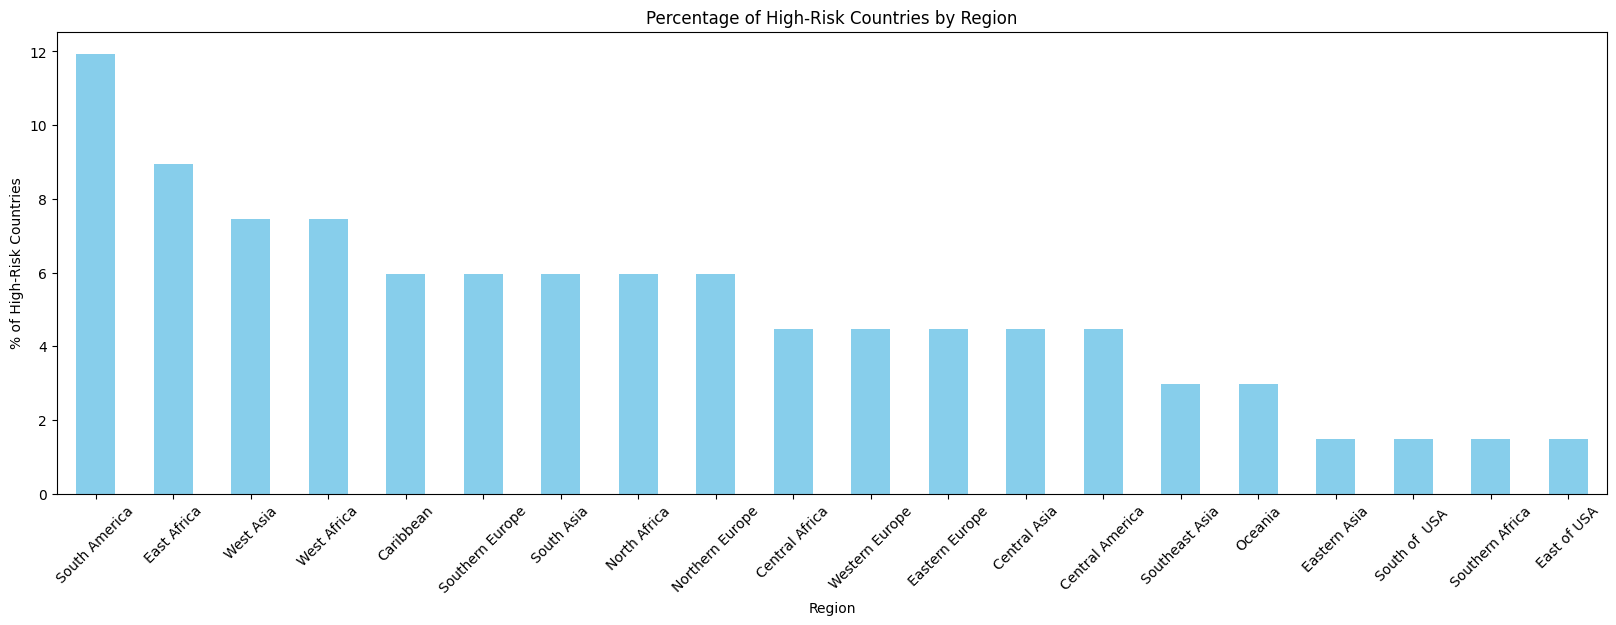

In [39]:
# 3.8 Model Application (Logistic Regression with Accuracy 97.51%)

# initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# fit the model on the sampled training data
logistic_model.fit(X_train, y_train)

# make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

# evaluate the model's performance
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)

# prepare data
segment_data = underperforming_data.copy()

# define required features and categorical columns
required_features = [
    'Actual days for shipping',
    'Discount Percentage',
    'Order Item Quantity',
    'Returns',
    'Scheduled days for shipping'
]
categorical_columns = ['Order Country', 'Order Region', 'Order State']


# encode categorical columns
for column in categorical_columns:
    if segment_data[column].dtype == 'object':
        all_values = pd.concat([underperforming_data[column], segment_data[column]]).unique()
        label_encoders[column].fit(all_values)
        segment_data[column] = label_encoders[column].transform(segment_data[column])

# ensure feature names and order match exactly with training data
try:
    model_feature_order = logistic_model.feature_names_in_
    features_country = segment_data[model_feature_order]
except AttributeError:
    model_feature_order = [
        'Actual days for shipping',
        'Discount Percentage',
        'Order Item Quantity',
        'Returns',
        'Scheduled days for shipping',
        'Order Country',
        'Order Region',
        'Order State'
    ]
    features_country = segment_data[model_feature_order]


# predict Late Delivery Risk probabilities
segment_data['Predicted_Late_Delivery_Risk'] = logistic_model.predict_proba(features_country)[:, 1]


# identify High-Risk Segments (>= 60% Predicted Risk)
high_risk_segments = (
    segment_data.groupby(['Order Country', 'Order Region'])
    .agg(avg_predicted_risk=('Predicted_Late_Delivery_Risk', 'mean'))
    .reset_index()
)
high_risk_segments = high_risk_segments[high_risk_segments['avg_predicted_risk'] >= 0.6]

# decode country and region names for easier interpretation
high_risk_segments['Order Country'] = high_risk_segments['Order Country'].apply(
    lambda x: label_encoders['Order Country'].inverse_transform([x])[0]
)
high_risk_segments['Order Region'] = high_risk_segments['Order Region'].apply(
    lambda x: label_encoders['Order Region'].inverse_transform([x])[0]
)

# sort high-risk segments by avg_predicted_risk in descending order
high_risk_segments_sorted = high_risk_segments.sort_values(by='avg_predicted_risk', ascending=False)

print(high_risk_segments_sorted.head(10))

# summarize High-Risk Segments by Region
high_risk_summary = high_risk_segments.groupby('Order Region').agg(
    High_Risk_Country_Count=('Order Country', 'nunique'),
    High_Risk_Countries=('Order Country', lambda x: list(x.unique()))
)

# calculate the percentage of high-risk countries by region
total_high_risk_countries = high_risk_summary['High_Risk_Country_Count'].sum()
high_risk_summary['Percentage of High-Risk Countries'] = (
    high_risk_summary['High_Risk_Country_Count'] / total_high_risk_countries * 100
)

# sort the summary in descending order by Percentage of High-Risk Countries
high_risk_summary = high_risk_summary.sort_values(by='Percentage of High-Risk Countries', ascending=False)

# print the high-risk summary
print(high_risk_summary)

# visualize the Percentage of High-Risk Countries by Region in Descending Order
plt.figure(figsize=(20, 6))
high_risk_summary['Percentage of High-Risk Countries'].plot(kind='bar', color='skyblue')
plt.title("Percentage of High-Risk Countries by Region")
plt.xlabel("Region")
plt.ylabel("% of High-Risk Countries")
plt.xticks(rotation=45)
plt.show()


In [41]:
# 3.9 Strategies to Improve Supply Chain Efficiency

# 1. Expedite customs processes with priority shipping in high-delay regions
#    - Focus on countries with lengthy customs clearance processes by investing in priority handling and fast-track options
#    - Example: Partner with local customs brokers in countries like Zimbabwe and Venezuela to streamline entry procedures
#    - Example: Utilize bonded warehouses near major ports to expedite goods transfer and avoid customs delays in specific regions

# 2. Strengthen partnerships with reliable regional carriers
#    - Enhance partnerships with regional carriers that have established routes and efficient networks in remote areas
#    - Example: Collaborate with established carriers in Papua New Guinea to navigate difficult terrain and improve delivery times
#    - Example: In politically sensitive regions such as Venezuela, work with carriers experienced in handling complex local conditions

# 3. Implement flexible shipping schedules for volatile regions
#    - Allow for dynamic scheduling to accommodate sudden changes in high-risk areas, improving delivery adaptability
#    - Example: In regions like West Asia, introduce flexible shipping options that adjust routes based on real-time data on political or weather conditions
#    - Example: Build a buffer into delivery timelines for regions with potential disruptions, reducing overall late delivery rates

# 4. Monitor and assess high-risk areas continuously
#    - Utilize predictive models to keep track of high-risk regions and allocate resources based on changing risk levels
#    - Example: Regularly evaluate the logistic regression model to update high-risk countries and adjust strategies as necessary
#    - Example: Use insights to forecast delays in South America and East Africa, and prioritize these areas in supplier engagement

# These targeted strategies are designed to reduce delays, improve efficiency, and ultimately enhance overall supply chain performance.
